In [1]:
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as md
np.set_printoptions(threshold=sys.maxsize)

In [2]:
arr = np.genfromtxt("./trade_prices_eth.csv", delimiter=",")
tm = np.array([datetime.datetime.fromtimestamp(ts/1000) for ts in arr[:,0]]).reshape(len(arr[:,0]),1)
tm = tm[:-10000]
prices = arr[:,1].reshape(len(arr[:,1]),1)
prices = prices[:-10000]

KeyboardInterrupt: 

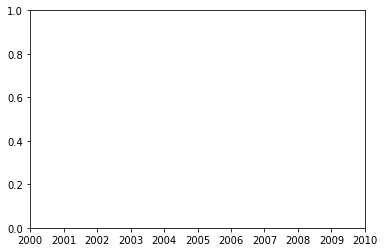

In [3]:
plt.plot(tm, prices)
plt.ylabel("ETH Price")
plt.xlabel("Date")
plt.xticks(rotation=25)
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)
plt.show()

In [4]:
#Optimisation method for time window and multiplication factor:
# - Calculate std = sqrt(Mean(log(Pt/Pt-1)**2)) for a certain time window, shifting the window over the whole 1 year period
# - Multiply by k
# - Check that we have for the full 1 year period k*std > log(Pt+1/Pt)

In [11]:
jump = 5
prices_update = prices[::jump]
time = tm[::jump]
returns = np.log(prices_update[1:]/prices_update[:-1])
skips = time[1:] - time[:-1] < datetime.timedelta(seconds=6)
time = time[1:]
time = time[skips]
returns = returns[skips]
returns[np.isnan(returns)] = 0

In [149]:
np.sum(np.isnan(returns))

0

In [6]:
ks = [temp for temp in range(20,30)]
time_windows = [time*jump for time in range(5, 12)]
min_diff = 10
min_k = 0
min_window = 0
def target(v):
    time_window = int(v[0])
    sq_returns = returns**2
    #stds = [
    #    np.sqrt(np.mean(sq_returns[i-time_window:i]))
    #        for i in range(time_window, len(returns))
    #]
    ema = 0
    alpha = 0.9999
    stds = []
    for i in range(len(returns)):
        ema = alpha * ema + (1-alpha) * returns[i]**2
        stds.append(np.sqrt(ema))

    stds = np.array(stds)
    print(stds.shape)
    target = np.maximum(stds, np.log(1.01))
    ret = returns[10000:]
    stds = stds[10000:]
    diff = stds - ret
    argmin = np.argmin(diff)
    # You want 0 = k * stds - returns
    k = ret[argmin] / stds[argmin]
    print(time_window, k, ret[argmin], stds[argmin])
    return k

In [199]:
target([10])

(3700298,)
10 42.21847695880411 0.029036478303996586 0.0006877670725149504


42.21847695880411

In [160]:
from scipy.optimize import brute
brute(target, (slice(1, 12, 1),), workers=15)

(3700296,)
2 4.197839279287079 0.029036478303996586 0.0069170057194109305
(3700287,)
11 5.443445095042306 0.029036478303996586 0.00533420982429711
(3700291,)
7 4.921338248653192 0.029036478303996586 0.005900118389940564
(3700293,)
5 4.6720212321023284 0.029036478303996586 0.006214971392784248
(3700289,)
9 5.3022907978027405 0.029036478303996586 0.005476213850064438
(3700292,)
6 4.867631144137326 0.029036478303996586 0.005965217462906717
(3700297,)
1 3.186620892498459 0.029036478303996586 0.009111996463824925
(3700294,)
4 5.370183812971093 0.029036478303996586 0.005406980340945154
(3700290,)
8 5.02256486616523 0.029036478303996586 0.005781205236313091
(3700295,)
3 5.118009117481599 0.029036478303996586 0.005673393235040672
(3700288,)
10 5.446342438013344 0.029036478303996586 0.005331372133586992
(3700297,)
1 3.186620892498459 0.029036478303996586 0.009111996463824925
(3700297,)
1 3.186620892498459 0.029036478303996586 0.009111996463824925


/home/loracle/.local/share/virtualenvs/loracle-kszUIQM7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/loracle/.local/share/virtualenvs/loracle-kszUIQM7/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [7]:
ema = 0
alpha = 0.9999
stds = []
for i in range(len(returns)):
    ema = alpha * ema + (1-alpha) * returns[i]**2
    stds.append(np.sqrt(ema))


In [12]:
print(returns.shape)
print(time.shape)

(3700298,)
(3700298,)


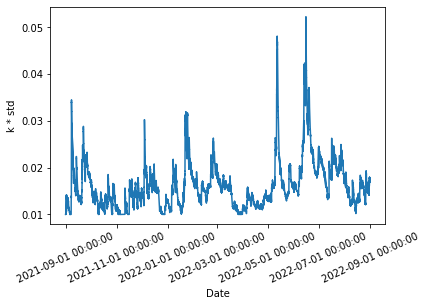

In [16]:
v = np.array(stds) * 42
v[v < 0.01] = 0.01
plt.plot(time, v)
plt.ylabel("k * std")
plt.xlabel("Date")
plt.xticks(rotation=25)
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)
plt.show()


In [208]:
halfLife = -np.log(2) / np.log(alpha)
print(halfLife * 5 /60/60)

9.626562814213084


In [24]:
# Test and debugging
ratio = int(time_window / jump)
k = 20
skips = time[ratio+1:-1] - time[ratio:-2] < datetime.timedelta(seconds=6)

stds = [
    np.sqrt(np.mean((np.log(prices_update[i-ratio+1:i+1]/prices_update[i-ratio:i]))**2)) 
        for i in range(ratio, len(prices_update)-2)
]
stds = np.array(stds).reshape(len(stds),1)
returns = np.abs(np.log(prices_update[ratio+1:-1]/prices_update[ratio:-2]))
diff = np.maximum(k*stds[skips], np.log(1.01)) - returns[skips]
minimum = min(diff)

In [27]:
print(np.where(diff<0))
index = 3009194
ret = returns[skips]
t = time[ratio:-2][skips]
print("PRICE SKIPPED", prices_update[ratio+1:-1][skips][index], prices_update[ratio:-2][skips][index])
print(t[index], t[index+1])
print("DIFF", diff[index])

(array([3009194]),)
PRICE SKIPPED 1200.0189671858275 1181.3894268138151
2022-06-24 13:31:49.999000 2022-06-24 13:31:54.999000
DIFF -0.0009602334239460133


In [10]:
def normal_to_jump(index_normal):
    return int(index_normal/5) - ratio

In [11]:
def jump_to_normal(index_jump):
    return (index_jump + ratio) * 5